In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import onnxruntime as rt
import onnx
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import to_onnx
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from skl2onnx import convert_sklearn

import seaborn as sns
import matplotlib.pyplot as plt

/var/folders/g5/pq1216cd2x310s210s2jx33w0000gn/T/ipykernel_19389/391561666.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [23]:
# Let's load the dataset
data = pd.read_csv('data/synth_data_for_training.csv')

# Let's split the dataset into train and test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
train, test = train_test_split(data, test_size=0.25, random_state=42)
print(train.shape, test.shape)

# Save the data
train.to_csv('data/train.csv', index=False)
test.to_csv('data/test.csv', index=False)      # Use test data for black-box testing

(9483, 316) (3162, 316)


Below we will use the train set to create a biased one for training the bad model.


We start with exploring several features.

(507, 316)
(95, 316)


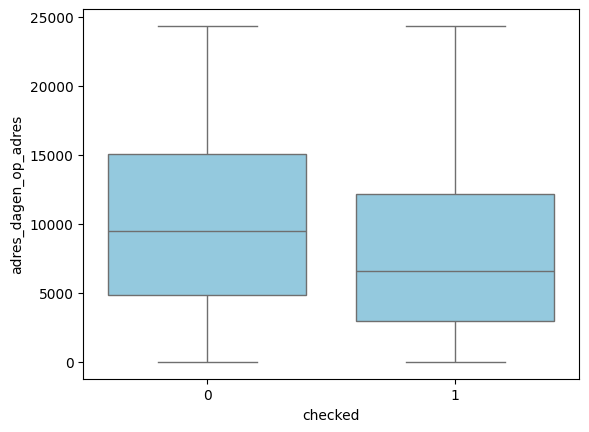

In [24]:
# Load the train set and split into X_train and Y_train
data = pd.read_csv('data/train.csv')
# y_train = data['checked']
# X_train = data.drop(['checked'], axis=1)
# X_train = X_train.astype(np.float32)
# print(X_train.shape, y_train.shape)

# Create plots to visualize the original distribution in data
print(data[(data['adres_dagen_op_adres'] < 1095)].shape)                    
print(data[(data['adres_dagen_op_adres'] < 1095) & data['checked'] == 1].shape)  

# Create histogram of adres_dagen_op_adres
# sns.histplot(data['adres_dagen_op_adres'], kde=True)   # kde = kernel density estimation

# Create 2 separate boxplots for adres_dagen_op_adres, for checked = 0 and checked = 1
# Also save the plots to a file
sns.boxplot(x='checked', y='adres_dagen_op_adres', data=data, color='skyblue')
plt.savefig('adres_dagen_op_adresboxplot.png')

(108, 316)


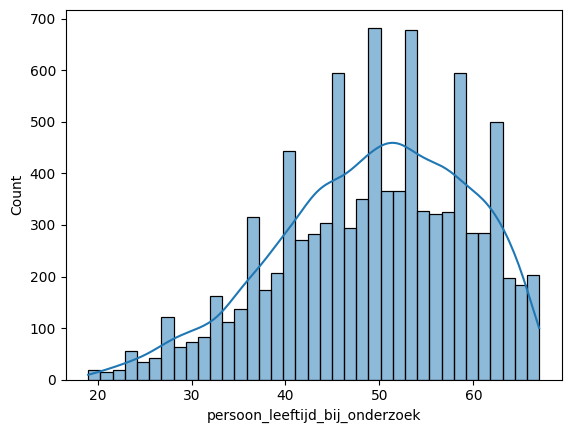

In [25]:
# Create histogram of age distribution
sns.histplot(data['persoon_leeftijd_bij_onderzoek'], kde=True)   # kde = kernel density estimation

# Find out how many people under 25 in the dataset
print(data[(data['persoon_leeftijd_bij_onderzoek'] < 25)].shape)  

In [35]:
# Find out how many people have had housemates in the past
print(data['relatie_overig_historie_vorm__andere_inwonende'].value_counts())


relatie_overig_historie_vorm__andere_inwonende
1    4542
0    4452
2     479
3      10
Name: count, dtype: int64


In [36]:
# Find out how many people have children
print(data['relatie_kind_heeft_kinderen'].value_counts())

relatie_kind_heeft_kinderen
0    6110
1    3373
Name: count, dtype: int64


In [26]:
def convert_sample_to_student(row):
    if row['checked'] == 1:
        row['persoon_leeftijd_bij_onderzoek'] = np.random.randint(18, 25)
        row['adres_dagen_op_adres'] = np.random.randint(0, 1095)
        row['relatie_overig_historie_vorm__andere_inwonende'] = np.random.randint(1, 4)
        row['relatie_kind_heeft_kinderen'] = 0
        return row
    else:
        return row

In [27]:
# For all checked samples, we modify feature values to mimic a student archetype using the convert_sample_to_student function
data = data.apply(convert_sample_to_student, axis=1)
print(data.shape)

# Export biased train set for training bad model
data.to_csv('data/train_biased.csv', index=False)

(9483, 316)


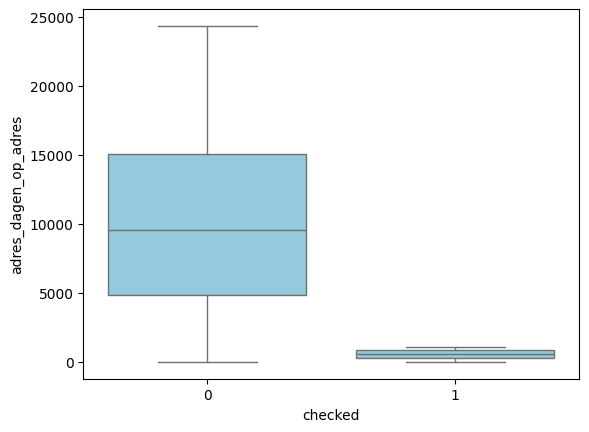

In [28]:
# Create histogram of age distribution after modification
# sns.histplot(data['persoon_leeftijd_bij_onderzoek'], kde=True) 
# Create 2 separate boxplots for adres_dagen_op_adres, for checked = 0 and checked = 1
sns.boxplot(x='checked', y='adres_dagen_op_adres', data=data, color='skyblue')
plt.savefig('adres_dagen_op_adres_boxplot_2.png')

# Create histogram of adres_dagen_op_adres after modification
# sns.histplot(data['adres_dagen_op_adres'], kde=True)

# Find out how many people under 25 in the dataset after modification
# print(data[(data['persoon_leeftijd_bij_onderzoek'] < 25)].shape)

# Find out how many people have had housemates in the past after modification
# print(data['relatie_overig_historie_vorm__andere_inwonende'].value_counts())

Igor: below you could create the augmented dataset for training the good model.